This data comes from an open access publication in Nature Scientific Data. There
are multiple versions available, the latest version available on 23-04-2021 was 
downloaded:
https://figshare.com/collections/Soccer_match_event_dataset/4415000/5

The author published two works related to this dataset, both are available in 
this folder for your convenience:
1) data_paper_soccer_nsd.pdf
2) PlayeRank_paper.pdf

All available data can be found in the subfolder "Data".
Additionally, the authors provided a Jupyter notebook to replicate the figures 
of their paper. This can be found in the subfolder "Code".

In [2]:
import json
from collections import Counter
import numpy as np
import operator
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse
import seaborn as sns
import pandas as pd
import networkx as nx
import base64
from collections import defaultdict
import sys,os
import math
import random
import operator
import csv
import matplotlib.pylab as pyl
import itertools
import scipy as sp
from scipy import stats
from scipy import optimize
from scipy.integrate import quad

import warnings
warnings.filterwarnings('ignore')

In [3]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

In [4]:
# setting up dataframe which will be updated throughout the notebook
final_df = pd.DataFrame()

In [5]:
# get data from european championship 
euro_events = events['European_Championship']

euro_events = pd.DataFrame(euro_events)
# find type of events 'subEventName' and inclue the API eventid that corresponds to it
subevent = euro_events['subEventName'].value_counts()

# select all the simple pass events
simple_pass = euro_events[euro_events['subEventName']=='Simple pass']

# seect all Ground defending duel events
ground_defending_duel = euro_events[euro_events['subEventName']=='Ground defending duel']

#select all High pass events
high_pass = euro_events[euro_events['subEventName']=='High pass']

# select counter attack events
shots = euro_events[euro_events['subEventName']=='Shot']

subevent

subEventName
Simple pass                33508
Ground attacking duel       6463
Ground defending duel       6144
Air duel                    4703
Ground loose ball duel      3791
High pass                   2961
Touch                       2836
Head pass                   2799
Throw in                    2168
Cross                       1812
Clearance                   1723
Foul                        1216
Shot                        1198
Launch                      1197
Smart pass                   985
Goal kick                    963
Free Kick                    823
Acceleration                 562
Corner                       532
Hand pass                    433
Reflexes                     270
Save attempt                 222
Free kick cross              221
                             189
Goalkeeper leaving line      174
Free kick shot                85
Hand foul                     58
Penalty                       49
Protest                       22
Late card foul                

In [6]:
shots

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
8,10,Shot,"[{'id': 402}, {'id': 1401}, {'id': 1203}, {'id...",25437,"[{'y': 29, 'x': 91}, {'y': 0, 'x': 0}]",1694390,Shot,4418,1H,31.226217,100,88178649
43,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1216}, {'id'...",83824,"[{'y': 29, 'x': 71}, {'y': 100, 'x': 100}]",1694390,Shot,11944,1H,143.119551,100,88178722
59,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...",33235,"[{'y': 57, 'x': 96}, {'y': 100, 'x': 100}]",1694390,Shot,11944,1H,219.576026,100,88178751
69,10,Shot,"[{'id': 403}, {'id': 201}, {'id': 1215}, {'id'...",6165,"[{'y': 61, 'x': 96}, {'y': 100, 'x': 100}]",1694390,Shot,11944,1H,247.532561,100,88373458
162,10,Shot,"[{'id': 401}, {'id': 2101}, {'id': 1802}]",3682,"[{'y': 33, 'x': 75}, {'y': 0, 'x': 0}]",1694390,Shot,4418,1H,557.319065,100,88178811
...,...,...,...,...,...,...,...,...,...,...,...,...
77555,10,Shot,"[{'id': 401}, {'id': 2101}, {'id': 1802}]",25575,"[{'y': 61, 'x': 78}, {'y': 100, 'x': 100}]",1694440,Shot,4418,2H,2417.929689,100,90588469
77665,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1218}, {'id'...",25575,"[{'y': 42, 'x': 93}, {'y': 100, 'x': 100}]",1694440,Shot,4418,2H,2776.503714,100,90588583
77897,10,Shot,"[{'id': 403}, {'id': 201}, {'id': 1203}, {'id'...",70410,"[{'y': 38, 'x': 90}, {'y': 0, 'x': 0}]",1694440,Shot,9905,E1,807.317501,100,90589205
77967,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",70410,"[{'y': 46, 'x': 77}, {'y': 0, 'x': 0}]",1694440,Shot,9905,E2,204.427888,100,90589254


In [7]:
# in euro events, create a new column called distance which calculates the distance between the start and end location of the event which is in the form of a list with two dictionaries consisting of y and x coordinates. 
# only compute the distance if there are two dictionaries in the list
euro_events['distance'] = euro_events['positions'].apply(lambda x: np.nan if len(x)!=2 else np.sqrt((x[0]['x']-x[1]['x'])**2 + (x[0]['y']-x[1]['y'])**2))

In [8]:
import pandas as pd

# I need to start to aggregate the events data by match and team. 

# find type of events 'subEventName'
subevent = euro_events['subEventName'].value_counts()

# find all types of events with "pass"
pass_events = euro_events[euro_events['subEventName'].str.contains('pass',case=False)]
pass_events['subEventName'].value_counts()

# I will start with the following: aggregate the data for each match and team, and count the total number of passes for each type ("Simple pass", "High pass", "Head pass", "Smart pass", "Hand pass"). 
pass_data = pass_events.groupby(['matchId','teamId','subEventName']).size().unstack().fillna(0)
pass_data = pass_data.reset_index()
pass_data.columns = ['matchId','teamId','Hand pass','Head pass','High pass','Simple pass','Smart pass']

final_df = pass_data

In [9]:
euro_events

def calculate_average_distance_for_subevent(df, subEventName):
    # Filter the dataset for the specified subEventName
    filtered_df = df[df['subEventName'] == subEventName]
    
    # Calculate the distance for each event
    # Assuming positions are stored as [{'x': startX, 'y': startY}, {'x': endX, 'y': endY}]
    filtered_df['distance'] = filtered_df.apply(lambda row: np.sqrt((row['positions'][1]['x'] - row['positions'][0]['x'])**2 + (row['positions'][1]['y'] - row['positions'][0]['y'])**2), axis=1)
    
    # Group by matchId and teamId, then calculate the average distance
    result = filtered_df.groupby(['matchId', 'teamId'])['distance'].mean().reset_index()
    
    # Rename the distance column to 'average_distance'
    result.rename(columns={'distance': 'average_distance'}, inplace=True)
    
    return result

# Calculate the average distance for each subevent
simple_pass_avg_distance = calculate_average_distance_for_subevent(euro_events, 'Simple pass')
high_pass_avg_distance = calculate_average_distance_for_subevent(euro_events, 'High pass')
head_pass_avg_distance = calculate_average_distance_for_subevent(euro_events, 'Head pass')
smart_pass_avg_distance = calculate_average_distance_for_subevent(euro_events, 'Smart pass')
hand_pass_avg_distance = calculate_average_distance_for_subevent(euro_events, 'Hand pass')

# Merge the results
final_df = final_df.merge(simple_pass_avg_distance, on=['matchId', 'teamId'], how='left', suffixes=('', '_simple_pass'))
final_df = final_df.merge(high_pass_avg_distance, on=['matchId', 'teamId'], how='left', suffixes=('', '_high_pass'))
final_df = final_df.merge(head_pass_avg_distance, on=['matchId', 'teamId'], how='left', suffixes=('', '_head_pass'))
final_df = final_df.merge(smart_pass_avg_distance, on=['matchId', 'teamId'], how='left', suffixes=('', '_smart_pass'))
final_df = final_df.merge(hand_pass_avg_distance, on=['matchId', 'teamId'], how='left', suffixes=('', '_hand_pass'))

final_df

,matchId,teamId,Hand pass,Head pass,High pass,Simple pass,Smart pass,average_distance,average_distance_high_pass,average_distance_head_pass,average_distance_smart_pass,average_distance_hand_pass
0,1694390,4418,0.0,46.0,19.0,396.0,13.0,19.394016,48.075074,15.987258,24.947164,NaN
1,1694390,11944,3.0,41.0,42.0,159.0,5.0,17.628175,40.821654,18.372292,31.589988,42.937888
2,1694391,6697,5.0,17.0,29.0,431.0,32.0,22.183961,45.569438,17.236032,22.737232,34.082376
3,1694391,8731,6.0,24.0,37.0,279.0,9.0,18.680556,48.308887,19.938841,20.591751,29.216470
4,1694392,6697,6.0,27.0,45.0,399.0,13.0,19.322826,45.631495,14.759804,26.873417,27.183459
...,...,...,...,...,...,...,...,...,...,...,...,...
97,1694438,10682,7.0,26.0,42.0,392.0,9.0,22.700453,47.680335,18.641629,21.441781,25.828836
98,1694439,3148,1.0,25.0,32.0,541.0,7.0,23.257933,51.219814,20.267864,27.341405,52.773099
99,1694439,4418,3.0,23.0,15.0,205.0,6.0,21.434028,45.154517,16.613264,28.804699,42.678212
100,1694440,4418,3.0,26.0,22.0,606.0,10.0,22.883618,46.842089,19.915861,20.430156,51.031275


In [10]:
# now we will calculate the proportion of each type of pass to the total number of passes for each match and team.
final_df['total_passes'] = final_df['Hand pass'] + final_df['Head pass'] + final_df['High pass'] + final_df['Simple pass'] + final_df['Smart pass']
final_df['Proportion Hand pass'] = final_df['Hand pass'] / final_df['total_passes']
final_df['Proportion Head pass'] = final_df['Head pass'] / final_df['total_passes']
final_df['Proportion High pass'] = final_df['High pass'] / final_df['total_passes']
final_df['Proportion Simple pass'] = final_df['Simple pass'] / final_df['total_passes']
final_df['Proportion Smart pass'] = final_df['Smart pass'] / final_df['total_passes']

# change NAN values to 0 in the dataframe
final_df = final_df.fillna(0)

In [11]:
# calculating the average pass length over all passes by each team in each match. This is done by summing the distance of all passes and dividing by the total number of passes.
final_df['average_pass_length'] = (final_df['Hand pass']*final_df['average_distance_hand_pass'] + final_df['Head pass']*final_df['average_distance_head_pass'] + final_df['High pass']*final_df['average_distance_high_pass'] + final_df['Simple pass']*final_df['average_distance'] + final_df['Smart pass']*final_df['average_distance_smart_pass']) / final_df['total_passes']

final_df

,matchId,teamId,Hand pass,Head pass,High pass,Simple pass,Smart pass,average_distance,average_distance_high_pass,average_distance_head_pass,average_distance_smart_pass,average_distance_hand_pass,total_passes,Proportion Hand pass,Proportion Head pass,Proportion High pass,Proportion Simple pass,Proportion Smart pass,average_pass_length
0,1694390,4418,0.0,46.0,19.0,396.0,13.0,19.394016,48.075074,15.987258,24.947164,0.000000,474.0,0.000000,0.097046,0.040084,0.835443,0.027426,20.365367
1,1694390,11944,3.0,41.0,42.0,159.0,5.0,17.628175,40.821654,18.372292,31.589988,42.937888,250.0,0.012000,0.164000,0.168000,0.636000,0.020000,22.229667
2,1694391,6697,5.0,17.0,29.0,431.0,32.0,22.183961,45.569438,17.236032,22.737232,34.082376,514.0,0.009728,0.033074,0.056420,0.838521,0.062257,23.489916
3,1694391,8731,6.0,24.0,37.0,279.0,9.0,18.680556,48.308887,19.938841,20.591751,29.216470,355.0,0.016901,0.067606,0.104225,0.785915,0.025352,22.080171
4,1694392,6697,6.0,27.0,45.0,399.0,13.0,19.322826,45.631495,14.759804,26.873417,27.183459,490.0,0.012245,0.055102,0.091837,0.814286,0.026531,21.784071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1694438,10682,7.0,26.0,42.0,392.0,9.0,22.700453,47.680335,18.641629,21.441781,25.828836,476.0,0.014706,0.054622,0.088235,0.823529,0.018908,24.705067
98,1694439,3148,1.0,25.0,32.0,541.0,7.0,23.257933,51.219814,20.267864,27.341405,52.773099,606.0,0.001650,0.041254,0.052805,0.892739,0.011551,24.706989
99,1694439,4418,3.0,23.0,15.0,205.0,6.0,21.434028,45.154517,16.613264,28.804699,42.678212,252.0,0.011905,0.091270,0.059524,0.813492,0.023810,22.834371
100,1694440,4418,3.0,26.0,22.0,606.0,10.0,22.883618,46.842089,19.915861,20.430156,51.031275,667.0,0.004498,0.038981,0.032984,0.908546,0.014993,23.647986


In [12]:
# let's calculate the average progression of passes for each team in each match. 
# Progression is calculatated using the x coordinate. Let's calculate the distance for each pass and then sum the distances for all passes for each type of pass.

def calculate_progression_for_subevent(df, subEventName):
    # Filter the dataset for the specified subEventName
    filtered_df = df[df['subEventName'] == subEventName]
    
    # Calculate the progression for each event using only the x coordinate
    # Positions are stored in y and then x format
    filtered_df['progression'] = filtered_df.apply(lambda row: row['positions'][1]['x'] - row['positions'][0]['x'], axis=1)
    
    # Group by matchId and teamId, then calculate the average progression per pass
    result = filtered_df.groupby(['matchId', 'teamId'])['progression'].mean().reset_index()
    
    # Rename the progression column to 'average_progression_per_pass'
    result.rename(columns={'progression': 'average_progression_per_pass'}, inplace=True)
    
    return result

# Calculate the average progression per pass for each subevent
simple_pass_avg_progression = calculate_progression_for_subevent(euro_events, 'Simple pass')
high_pass_avg_progression = calculate_progression_for_subevent(euro_events, 'High pass')
head_pass_avg_progression = calculate_progression_for_subevent(euro_events, 'Head pass')
smart_pass_avg_progression = calculate_progression_for_subevent(euro_events, 'Smart pass')
hand_pass_avg_progression = calculate_progression_for_subevent(euro_events, 'Hand pass')

# Merge the results
final_df = final_df.merge(simple_pass_avg_progression, on=['matchId', 'teamId'], how='left', suffixes=('', '_simple_pass'))
final_df = final_df.merge(high_pass_avg_progression, on=['matchId', 'teamId'], how='left', suffixes=('', '_high_pass'))
final_df = final_df.merge(head_pass_avg_progression, on=['matchId', 'teamId'], how='left', suffixes=('', '_head_pass'))
final_df = final_df.merge(smart_pass_avg_progression, on=['matchId', 'teamId'], how='left', suffixes=('', '_smart_pass'))
final_df = final_df.merge(hand_pass_avg_progression, on=['matchId', 'teamId'], how='left', suffixes=('', '_hand_pass'))

final_df
final_df = final_df.fillna(0)


In [13]:
final_df

,matchId,teamId,Hand pass,Head pass,High pass,Simple pass,Smart pass,average_distance,average_distance_high_pass,average_distance_head_pass,...,Proportion Head pass,Proportion High pass,Proportion Simple pass,Proportion Smart pass,average_pass_length,average_progression_per_pass,average_progression_per_pass_high_pass,average_progression_per_pass_head_pass,average_progression_per_pass_smart_pass,average_progression_per_pass_hand_pass
0,1694390,4418,0.0,46.0,19.0,396.0,13.0,19.394016,48.075074,15.987258,...,0.097046,0.040084,0.835443,0.027426,20.365367,2.618687,27.105263,9.543478,16.153846,0.000000
1,1694390,11944,3.0,41.0,42.0,159.0,5.0,17.628175,40.821654,18.372292,...,0.164000,0.168000,0.636000,0.020000,22.229667,3.584906,27.119048,7.317073,13.600000,28.333333
2,1694391,6697,5.0,17.0,29.0,431.0,32.0,22.183961,45.569438,17.236032,...,0.033074,0.056420,0.838521,0.062257,23.489916,3.150812,24.965517,3.294118,17.437500,23.400000
3,1694391,8731,6.0,24.0,37.0,279.0,9.0,18.680556,48.308887,19.938841,...,0.067606,0.104225,0.785915,0.025352,22.080171,2.867384,36.783784,5.375000,15.555556,18.166667
4,1694392,6697,6.0,27.0,45.0,399.0,13.0,19.322826,45.631495,14.759804,...,0.055102,0.091837,0.814286,0.026531,21.784071,3.390977,30.933333,5.111111,18.769231,15.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1694438,10682,7.0,26.0,42.0,392.0,9.0,22.700453,47.680335,18.641629,...,0.054622,0.088235,0.823529,0.018908,24.705067,3.813776,26.809524,4.615385,9.888889,16.142857
98,1694439,3148,1.0,25.0,32.0,541.0,7.0,23.257933,51.219814,20.267864,...,0.041254,0.052805,0.892739,0.011551,24.706989,4.107209,24.500000,7.680000,17.285714,24.000000
99,1694439,4418,3.0,23.0,15.0,205.0,6.0,21.434028,45.154517,16.613264,...,0.091270,0.059524,0.813492,0.023810,22.834371,3.682927,27.733333,7.608696,17.333333,36.666667
100,1694440,4418,3.0,26.0,22.0,606.0,10.0,22.883618,46.842089,19.915861,...,0.038981,0.032984,0.908546,0.014993,23.647986,3.645215,32.227273,10.346154,15.100000,37.666667


In [14]:
# There is a column 'tags' which contains a list of dictionaries. Each dictionary contains information about the event. If 1801 is in tags it was successful, if 1802 it was not successful.
# We will calculate the success rate for each type of pass for each team in each match.

def calculate_success_rate_for_subevent(df, subEventName):
    # Filter the dataset for the specified subEventName
    filtered_df = df[df['subEventName'] == subEventName]
    
    # Calculate the success rate for each event
    filtered_df['success'] = filtered_df['tags'].apply(lambda x: 1 if 1801 in [tag['id'] for tag in x] else 0)
    
    # Group by matchId and teamId, then calculate the success rate
    result = filtered_df.groupby(['matchId', 'teamId'])['success'].mean().reset_index()
    
    # Rename the success column to 'success_rate'
    result.rename(columns={'success': 'success_rate'}, inplace=True)
    
    return result

# Calculate the success rate for each subevent
simple_pass_success_rate = calculate_success_rate_for_subevent(euro_events, 'Simple pass')
high_pass_success_rate = calculate_success_rate_for_subevent(euro_events, 'High pass')
head_pass_success_rate = calculate_success_rate_for_subevent(euro_events, 'Head pass')
smart_pass_success_rate = calculate_success_rate_for_subevent(euro_events, 'Smart pass')
hand_pass_success_rate = calculate_success_rate_for_subevent(euro_events, 'Hand pass')

# Merge the results
final_df = final_df.merge(simple_pass_success_rate, on=['matchId', 'teamId'], how='left', suffixes=('', '_simple_pass'))
final_df = final_df.merge(high_pass_success_rate, on=['matchId', 'teamId'], how='left', suffixes=('', '_high_pass'))
final_df = final_df.merge(head_pass_success_rate, on=['matchId', 'teamId'], how='left', suffixes=('', '_head_pass'))
final_df = final_df.merge(smart_pass_success_rate, on=['matchId', 'teamId'], how='left', suffixes=('', '_smart_pass'))
final_df = final_df.merge(hand_pass_success_rate, on=['matchId', 'teamId'], how='left', suffixes=('', '_hand_pass'))


In [15]:
final_df = final_df.fillna(0)

# I don't think that hand passes are useful. Remove all columns that contain the word "hand"
final_df = final_df[final_df.columns.drop(list(final_df.filter(regex='hand')))]
final_df = final_df[final_df.columns.drop(list(final_df.filter(regex='Hand')))]

final_df

,matchId,teamId,Head pass,High pass,Simple pass,Smart pass,average_distance,average_distance_high_pass,average_distance_head_pass,average_distance_smart_pass,...,Proportion Smart pass,average_pass_length,average_progression_per_pass,average_progression_per_pass_high_pass,average_progression_per_pass_head_pass,average_progression_per_pass_smart_pass,success_rate,success_rate_high_pass,success_rate_head_pass,success_rate_smart_pass
0,1694390,4418,46.0,19.0,396.0,13.0,19.394016,48.075074,15.987258,24.947164,...,0.027426,20.365367,2.618687,27.105263,9.543478,16.153846,0.921717,0.684211,0.586957,0.230769
1,1694390,11944,41.0,42.0,159.0,5.0,17.628175,40.821654,18.372292,31.589988,...,0.020000,22.229667,3.584906,27.119048,7.317073,13.600000,0.849057,0.619048,0.756098,0.600000
2,1694391,6697,17.0,29.0,431.0,32.0,22.183961,45.569438,17.236032,22.737232,...,0.062257,23.489916,3.150812,24.965517,3.294118,17.437500,0.965197,0.586207,0.764706,0.593750
3,1694391,8731,24.0,37.0,279.0,9.0,18.680556,48.308887,19.938841,20.591751,...,0.025352,22.080171,2.867384,36.783784,5.375000,15.555556,0.960573,0.621622,0.750000,0.666667
4,1694392,6697,27.0,45.0,399.0,13.0,19.322826,45.631495,14.759804,26.873417,...,0.026531,21.784071,3.390977,30.933333,5.111111,18.769231,0.959900,0.555556,0.629630,0.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1694438,10682,26.0,42.0,392.0,9.0,22.700453,47.680335,18.641629,21.441781,...,0.018908,24.705067,3.813776,26.809524,4.615385,9.888889,0.938776,0.714286,0.538462,0.444444
98,1694439,3148,25.0,32.0,541.0,7.0,23.257933,51.219814,20.267864,27.341405,...,0.011551,24.706989,4.107209,24.500000,7.680000,17.285714,0.951941,0.593750,0.560000,0.285714
99,1694439,4418,23.0,15.0,205.0,6.0,21.434028,45.154517,16.613264,28.804699,...,0.023810,22.834371,3.682927,27.733333,7.608696,17.333333,0.912195,0.333333,0.782609,0.500000
100,1694440,4418,26.0,22.0,606.0,10.0,22.883618,46.842089,19.915861,20.430156,...,0.014993,23.647986,3.645215,32.227273,10.346154,15.100000,0.943894,0.727273,0.692308,0.400000


Now we start with feature construction for pressing

In [16]:
# Calculate PPDA, which is passes per defensive action. This takes all defensive actions into account which are defenive duels, sliding tackle, fouls. The defensive actions with x > 40 are the only ones that count. These actions need to be summed per match and team 
# Also, only the passes made by the opponent are counted that are x < 40. 

def calculate_PPDA(df):
    # Filter the dataset for the specified defensive actions
    defensive_actions = df[(df['subEventName'] == 'Ground defending duel') | (df['subEventName'] == 'Sliding tackle') | (df['subEventName'] == 'Foul')]
    
    # Calculate the PPDA for each defensive action
    defensive_actions['PPDA'] = defensive_actions['teamId'].apply(lambda x: 1)
    
    # Group by matchId and teamId, then calculate the PPDA
    result = defensive_actions.groupby(['matchId', 'teamId'])['PPDA'].sum().reset_index()
    
    # Filter the dataset for the specified passes
    passes = df[df['subEventName'] == 'Simple pass']
    
    # Calculate the PPDA for each pass
    passes['PPDA'] = passes['teamId'].apply(lambda x: 1)
    
    # Group by matchId and teamId, then calculate the PPDA
    passes = passes.groupby(['matchId', 'teamId'])['PPDA'].sum().reset_index()
    
    # Merge the results
    result = result.merge(passes, on=['matchId', 'teamId'], how='left', suffixes=('', '_passes'))
    
    # Calculate the PPDA
    result['PPDA'] = result['PPDA_passes'] / result['PPDA']

    # drop PPDA_passes column
    result = result.drop('PPDA_passes', axis=1)
    
    return result

# Calculate PPDA for each team
PPDA = calculate_PPDA(euro_events)

# merge the PPDA data with the final_df
final_df = final_df.merge(PPDA, on=['matchId', 'teamId'], how='left')

final_df

,matchId,teamId,Head pass,High pass,Simple pass,Smart pass,average_distance,average_distance_high_pass,average_distance_head_pass,average_distance_smart_pass,...,average_pass_length,average_progression_per_pass,average_progression_per_pass_high_pass,average_progression_per_pass_head_pass,average_progression_per_pass_smart_pass,success_rate,success_rate_high_pass,success_rate_head_pass,success_rate_smart_pass,PPDA
0,1694390,4418,46.0,19.0,396.0,13.0,19.394016,48.075074,15.987258,24.947164,...,20.365367,2.618687,27.105263,9.543478,16.153846,0.921717,0.684211,0.586957,0.230769,6.000000
1,1694390,11944,41.0,42.0,159.0,5.0,17.628175,40.821654,18.372292,31.589988,...,22.229667,3.584906,27.119048,7.317073,13.600000,0.849057,0.619048,0.756098,0.600000,1.500000
2,1694391,6697,17.0,29.0,431.0,32.0,22.183961,45.569438,17.236032,22.737232,...,23.489916,3.150812,24.965517,3.294118,17.437500,0.965197,0.586207,0.764706,0.593750,5.986111
3,1694391,8731,24.0,37.0,279.0,9.0,18.680556,48.308887,19.938841,20.591751,...,22.080171,2.867384,36.783784,5.375000,15.555556,0.960573,0.621622,0.750000,0.666667,4.227273
4,1694392,6697,27.0,45.0,399.0,13.0,19.322826,45.631495,14.759804,26.873417,...,21.784071,3.390977,30.933333,5.111111,18.769231,0.959900,0.555556,0.629630,0.461538,5.115385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1694438,10682,26.0,42.0,392.0,9.0,22.700453,47.680335,18.641629,21.441781,...,24.705067,3.813776,26.809524,4.615385,9.888889,0.938776,0.714286,0.538462,0.444444,6.125000
98,1694439,3148,25.0,32.0,541.0,7.0,23.257933,51.219814,20.267864,27.341405,...,24.706989,4.107209,24.500000,7.680000,17.285714,0.951941,0.593750,0.560000,0.285714,8.074627
99,1694439,4418,23.0,15.0,205.0,6.0,21.434028,45.154517,16.613264,28.804699,...,22.834371,3.682927,27.733333,7.608696,17.333333,0.912195,0.333333,0.782609,0.500000,2.971014
100,1694440,4418,26.0,22.0,606.0,10.0,22.883618,46.842089,19.915861,20.430156,...,23.647986,3.645215,32.227273,10.346154,15.100000,0.943894,0.727273,0.692308,0.400000,7.973684


In [17]:
# compute number of each defensive action per match and team. Defensive actions are: Ground defending duel, foul, ground loose ball duel, Ground attacking duel 
defensive_actions = euro_events[(euro_events['subEventName'] == 'Ground defending duel') | (euro_events['subEventName'] == 'Foul') | (euro_events['subEventName'] == 'Ground loose ball duel') | (euro_events['subEventName'] == 'Ground attacking duel')]
defensive_actions = defensive_actions.groupby(['matchId', 'teamId', 'subEventName']).size().unstack().fillna(0)
defensive_actions = defensive_actions.reset_index()
defensive_actions.columns = ['matchId','teamId','Foul','Ground attacking duel','Ground defending duel','Ground loose ball duel']

final_df = final_df.merge(defensive_actions, on=['matchId', 'teamId'], how='left')

final_df

,matchId,teamId,Head pass,High pass,Simple pass,Smart pass,average_distance,average_distance_high_pass,average_distance_head_pass,average_distance_smart_pass,...,average_progression_per_pass_smart_pass,success_rate,success_rate_high_pass,success_rate_head_pass,success_rate_smart_pass,PPDA,Foul,Ground attacking duel,Ground defending duel,Ground loose ball duel
0,1694390,4418,46.0,19.0,396.0,13.0,19.394016,48.075074,15.987258,24.947164,...,16.153846,0.921717,0.684211,0.586957,0.230769,6.000000,6,87,60,61
1,1694390,11944,41.0,42.0,159.0,5.0,17.628175,40.821654,18.372292,31.589988,...,13.600000,0.849057,0.619048,0.756098,0.600000,1.500000,11,65,95,63
2,1694391,6697,17.0,29.0,431.0,32.0,22.183961,45.569438,17.236032,22.737232,...,17.437500,0.965197,0.586207,0.764706,0.593750,5.986111,16,61,56,43
3,1694391,8731,24.0,37.0,279.0,9.0,18.680556,48.308887,19.938841,20.591751,...,15.555556,0.960573,0.621622,0.750000,0.666667,4.227273,8,63,58,38
4,1694392,6697,27.0,45.0,399.0,13.0,19.322826,45.631495,14.759804,26.873417,...,18.769231,0.959900,0.555556,0.629630,0.461538,5.115385,11,78,67,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1694438,10682,26.0,42.0,392.0,9.0,22.700453,47.680335,18.641629,21.441781,...,9.888889,0.938776,0.714286,0.538462,0.444444,6.125000,12,46,52,27
98,1694439,3148,25.0,32.0,541.0,7.0,23.257933,51.219814,20.267864,27.341405,...,17.285714,0.951941,0.593750,0.560000,0.285714,8.074627,7,68,60,27
99,1694439,4418,23.0,15.0,205.0,6.0,21.434028,45.154517,16.613264,28.804699,...,17.333333,0.912195,0.333333,0.782609,0.500000,2.971014,12,53,57,24
100,1694440,4418,26.0,22.0,606.0,10.0,22.883618,46.842089,19.915861,20.430156,...,15.100000,0.943894,0.727273,0.692308,0.400000,7.973684,13,94,63,32


In [18]:
# for each defensive action (Ground defending duel, foul, ground loose ball duel, Ground attacking duel ) in each match and team, calculate the average height of the action (x coordinate of the start position)
# given that location is stored like: [{'y': 29, 'x': 91}, {'y': 0, 'x': 0}]

def calculate_average_height_for_defensive_action(df, subEventName):
    # Filter the dataset for the specified subEventName
    filtered_df = df[df['subEventName'] == subEventName]
    
    # Calculate the height for each event
    # Assuming positions are stored as [{'x': startX, 'y': startY}, {'x': endX, 'y': endY}]
    filtered_df['height'] = filtered_df['positions'].apply(lambda x: x[0]['x'])
    
    # Group by matchId and teamId, then calculate the average height
    result = filtered_df.groupby(['matchId', 'teamId'])['height'].mean().reset_index()
    
    # Rename the height column to 'average_height'
    result.rename(columns={'height': 'average_height'}, inplace=True)
    
    return result

# Calculate the average height for each defensive action
ground_defending_duel_avg_height = calculate_average_height_for_defensive_action(euro_events, 'Ground defending duel')
foul_avg_height = calculate_average_height_for_defensive_action(euro_events, 'Foul')
ground_loose_ball_duel_avg_height = calculate_average_height_for_defensive_action(euro_events, 'Ground loose ball duel')
ground_attacking_duel_avg_height = calculate_average_height_for_defensive_action(euro_events, 'Ground attacking duel')

# Merge the results
final_df = final_df.merge(ground_defending_duel_avg_height, on=['matchId', 'teamId'], how='left', suffixes=('', '_ground_defending_duel'))
final_df = final_df.merge(foul_avg_height, on=['matchId', 'teamId'], how='left', suffixes=('', '_foul'))
final_df = final_df.merge(ground_loose_ball_duel_avg_height, on=['matchId', 'teamId'], how='left', suffixes=('', '_ground_loose_ball_duel'))
final_df = final_df.merge(ground_attacking_duel_avg_height, on=['matchId', 'teamId'], how='left', suffixes=('', '_ground_attacking_duel'))

final_df = final_df.fillna(0)

final_df

,matchId,teamId,Head pass,High pass,Simple pass,Smart pass,average_distance,average_distance_high_pass,average_distance_head_pass,average_distance_smart_pass,...,success_rate_smart_pass,PPDA,Foul,Ground attacking duel,Ground defending duel,Ground loose ball duel,average_height,average_height_foul,average_height_ground_loose_ball_duel,average_height_ground_attacking_duel
0,1694390,4418,46.0,19.0,396.0,13.0,19.394016,48.075074,15.987258,24.947164,...,0.230769,6.000000,6,87,60,61,38.416667,47.333333,49.655738,58.528736
1,1694390,11944,41.0,42.0,159.0,5.0,17.628175,40.821654,18.372292,31.589988,...,0.600000,1.500000,11,65,95,63,41.021053,54.454545,50.142857,60.907692
2,1694391,6697,17.0,29.0,431.0,32.0,22.183961,45.569438,17.236032,22.737232,...,0.593750,5.986111,16,61,56,43,40.607143,55.812500,48.255814,59.590164
3,1694391,8731,24.0,37.0,279.0,9.0,18.680556,48.308887,19.938841,20.591751,...,0.666667,4.227273,8,63,58,38,40.724138,51.875000,51.263158,58.539683
4,1694392,6697,27.0,45.0,399.0,13.0,19.322826,45.631495,14.759804,26.873417,...,0.461538,5.115385,11,78,67,47,37.179104,58.545455,43.148936,62.961538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1694438,10682,26.0,42.0,392.0,9.0,22.700453,47.680335,18.641629,21.441781,...,0.444444,6.125000,12,46,52,27,39.365385,53.166667,53.444444,63.391304
98,1694439,3148,25.0,32.0,541.0,7.0,23.257933,51.219814,20.267864,27.341405,...,0.285714,8.074627,7,68,60,27,45.983333,56.142857,56.222222,67.735294
99,1694439,4418,23.0,15.0,205.0,6.0,21.434028,45.154517,16.613264,28.804699,...,0.500000,2.971014,12,53,57,24,34.245614,53.416667,44.750000,51.924528
100,1694440,4418,26.0,22.0,606.0,10.0,22.883618,46.842089,19.915861,20.430156,...,0.400000,7.973684,13,94,63,32,37.285714,52.461538,50.843750,67.031915


In [19]:
# aggregate the data per team, count the total number of games each team has played and sum all the data for each team and divide by the number of games played
team_data = final_df.groupby('teamId').sum()
team_data['matches_played'] = final_df.groupby('teamId')['matchId'].nunique()
team_data = team_data.div(team_data['matches_played'], axis=0)
team_data = team_data.drop('matches_played', axis=1)

# drop matchId column
team_data = team_data.drop('matchId', axis=1)

team_data

,Head pass,High pass,Simple pass,Smart pass,average_distance,average_distance_high_pass,average_distance_head_pass,average_distance_smart_pass,total_passes,Proportion Head pass,...,success_rate_smart_pass,PPDA,Foul,Ground attacking duel,Ground defending duel,Ground loose ball duel,average_height,average_height_foul,average_height_ground_loose_ball_duel,average_height_ground_attacking_duel
teamId,,,,,,,,,,,,,,,,,,,,,
1598,19.250000,29.750000,537.500000,17.750000,19.936595,45.462313,18.530594,21.593337,609.000000,0.031879,...,0.573771,9.634977,12.500000,74.500000,50.250000,36.750000,46.098569,55.908741,55.991987,68.106128
2413,27.500000,27.000000,407.000000,12.500000,22.001425,48.097089,20.449828,20.523413,479.000000,0.058249,...,0.394981,7.801306,9.250000,82.250000,44.250000,36.500000,44.940138,61.708333,56.015043,67.606885
3148,23.333333,38.500000,546.333333,14.333333,21.893067,49.870773,19.500705,24.858137,627.666667,0.037428,...,0.417910,9.632794,10.333333,67.833333,51.666667,29.333333,44.909304,57.690934,55.477366,66.380220
3757,25.000000,37.600000,291.000000,12.400000,22.556156,45.340155,19.354994,28.721322,371.800000,0.068301,...,0.398006,4.514799,14.000000,48.000000,52.000000,45.200000,34.136333,53.701160,46.870370,57.947746
4418,31.714286,21.714286,400.571429,8.714286,21.690867,47.940305,18.652171,23.484799,465.285714,0.073649,...,0.350521,6.067948,10.142857,77.714286,56.428571,43.714286,38.377681,52.555220,50.244082,61.852858
4687,31.333333,29.000000,276.333333,4.666667,21.292222,41.126337,20.116882,19.516753,344.000000,0.096029,...,0.133333,3.986563,13.000000,60.333333,59.333333,42.666667,35.615539,52.238095,44.846456,56.858710
5629,21.400000,24.200000,347.400000,12.600000,22.212031,50.001780,21.774986,25.963128,410.800000,0.053690,...,0.413725,6.106843,9.400000,70.000000,49.200000,39.000000,37.988355,57.527619,51.343034,65.050456
6697,27.000000,32.750000,426.750000,17.750000,21.244131,45.966320,17.153430,25.686250,508.500000,0.052838,...,0.477874,5.428790,12.750000,72.750000,66.250000,39.500000,40.123745,58.308239,45.311440,64.023849
7047,35.000000,27.666667,279.666667,12.333333,21.513958,41.268665,18.096970,22.365270,360.000000,0.098967,...,0.420915,5.002732,12.666667,52.666667,44.000000,46.666667,35.612144,60.795238,55.623906,62.749945


In [20]:
# get the teams data from European_championship

with open('./data/teams.json') as json_data:
    teams = json.load(json_data)

teams = pd.DataFrame(teams)

# match the teamId from the final_df with the teamId from the teams data and the officialName of the team and store it into a disctionary
team_dict = dict(zip(teams['wyId'], teams['officialName']))

# add the officialName of the team to the team_data dataframe
team_data['team'] = team_data.index.map(team_dict)

# move the team column to the front of the dataframe
cols = team_data.columns.tolist()
cols = cols[-1:] + cols[:-1]
team_data = team_data[cols]


In [21]:
# change average_distance to average_distance_simple_pass
team_data = team_data.rename(columns={'average_distance': 'average_distance_simple_pass'})
# change sucess_rate to success_rate_simple_pass
team_data = team_data.rename(columns={'success_rate': 'success_rate_simple_pass'})
# change average_progression_per_pass to average_progression_per_pass_simple_pass
team_data = team_data.rename(columns={'average_progression_per_pass': 'average_progression_per_pass_simple_pass'})
# average_height to average_height_ground_defending_duel
team_data = team_data.rename(columns={'average_height': 'average_height_ground_defending_duel'})


In [22]:
# I have the variables for average distance for each pass type, now I want to combine those into a variable that represents the average distance for all passes.
# multiply number of passes with the distance for each pass type and sum all the distances and divide by the total number of passes
team_data['average_pass_distance'] = (team_data['Simple pass']*team_data['average_distance_simple_pass'] + team_data['High pass']*team_data['average_distance_high_pass'] + team_data['Head pass']*team_data['average_distance_head_pass'] + team_data['Smart pass']*team_data ['average_distance_smart_pass']) / team_data['total_passes']

# I want to calculate the average progression of the total passes 
team_data['average_pass_progression'] = (team_data['Simple pass']*team_data['average_progression_per_pass_simple_pass'] + team_data['High pass']*team_data['average_progression_per_pass_high_pass'] + team_data['Head pass']*team_data['average_progression_per_pass_head_pass'] + team_data['Smart pass']*team_data['average_progression_per_pass_smart_pass']) / team_data['total_passes']

# I want to calculate the average success rate of the total passes
# multiplying the number of passes with the success rate for each pass type and sum all the success rates and divide by the total number of passes
team_data['average_pass_success_rate'] = (team_data['Simple pass']*team_data['success_rate_simple_pass'] + team_data['High pass']*team_data['success_rate_high_pass'] + team_data['Head pass']*team_data['success_rate_head_pass'] + team_data['Smart pass']*team_data['success_rate_smart_pass']) / team_data['total_passes']



In [23]:
# change teamId to be a column and not the index of the dataframe
team_data = team_data.reset_index()

team_data

,teamId,team,Head pass,High pass,Simple pass,Smart pass,average_distance_simple_pass,average_distance_high_pass,average_distance_head_pass,average_distance_smart_pass,...,Ground attacking duel,Ground defending duel,Ground loose ball duel,average_height_ground_defending_duel,average_height_foul,average_height_ground_loose_ball_duel,average_height_ground_attacking_duel,average_pass_distance,average_pass_progression,average_pass_success_rate
0,1598,Spain,19.250000,29.750000,537.500000,17.750000,19.936595,45.462313,18.530594,21.593337,...,74.500000,50.250000,36.750000,46.098569,55.908741,55.991987,68.106128,21.031888,4.203898,0.910021
1,2413,England,27.500000,27.000000,407.000000,12.500000,22.001425,48.097089,20.449828,20.523413,...,82.250000,44.250000,36.500000,44.940138,61.708333,56.015043,67.606885,23.115061,5.550706,0.889995
2,3148,Germany,23.333333,38.500000,546.333333,14.333333,21.893067,49.870773,19.500705,24.858137,...,67.833333,51.666667,29.333333,44.909304,57.690934,55.477366,66.380220,23.407733,4.972187,0.904176
3,3757,Italy,25.000000,37.600000,291.000000,12.400000,22.556156,45.340155,19.354994,28.721322,...,48.000000,52.000000,45.200000,34.136333,53.701160,46.870370,57.947746,24.498791,6.356164,0.833703
4,4418,France,31.714286,21.714286,400.571429,8.714286,21.690867,47.940305,18.652171,23.484799,...,77.714286,56.428571,43.714286,38.377681,52.555220,50.244082,61.852858,22.622497,4.972338,0.892094
5,4687,Turkey,31.333333,29.000000,276.333333,4.666667,21.292222,41.126337,20.116882,19.516753,...,60.333333,59.333333,42.666667,35.615539,52.238095,44.846456,56.858710,22.668086,5.138561,0.852541
6,5629,Belgium,21.400000,24.200000,347.400000,12.600000,22.212031,50.001780,21.774986,25.963128,...,70.000000,49.200000,39.000000,37.988355,57.527619,51.343034,65.050456,23.660231,6.082000,0.879924
7,6697,Switzerland,27.000000,32.750000,426.750000,17.750000,21.244131,45.966320,17.153430,25.686250,...,72.750000,66.250000,39.500000,40.123745,58.308239,45.311440,64.023849,22.596663,5.574536,0.896502
8,7047,Sweden,35.000000,27.666667,279.666667,12.333333,21.513958,41.268665,18.096970,22.365270,...,52.666667,44.000000,46.666667,35.612144,60.795238,55.623906,62.749945,22.410377,5.270716,0.858669
9,7839,Iceland,29.600000,27.200000,163.600000,5.400000,20.308443,46.920936,18.968298,28.320050,...,40.400000,67.800000,35.000000,30.126954,47.377834,47.324608,57.469968,23.160857,7.422112,0.765151


In [24]:
# Let's do a PCA analysis to see if we can reduce the dimensionality of the data and if certain playstyles can be identified from the loadings 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# drop team from the data
features = team_data.drop(['teamId', 'team', 'cluster'], axis=1)

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(scaled_features)

# Create a dataframe with the principal components
pca_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])
pca_df['team'] = team_data['team']

print("explained variance ratio: ", pca.explained_variance_ratio_)
# total variance 
print("total variance explained: ", sum(pca.explained_variance_ratio_))

# plot heatmap of pca_df, use the team names as y axis and the principal components as x axis
plt.figure(figsize=(16, 10))
sns.heatmap(pca_df.drop('team', axis=1), annot=True, cmap='coolwarm')
plt.yticks(ticks=range(len(pca_df['team'])), labels=pca_df['team'], rotation=0)
plt.title('PCA components')
plt.show()








KeyError: "['cluster'] not found in axis"

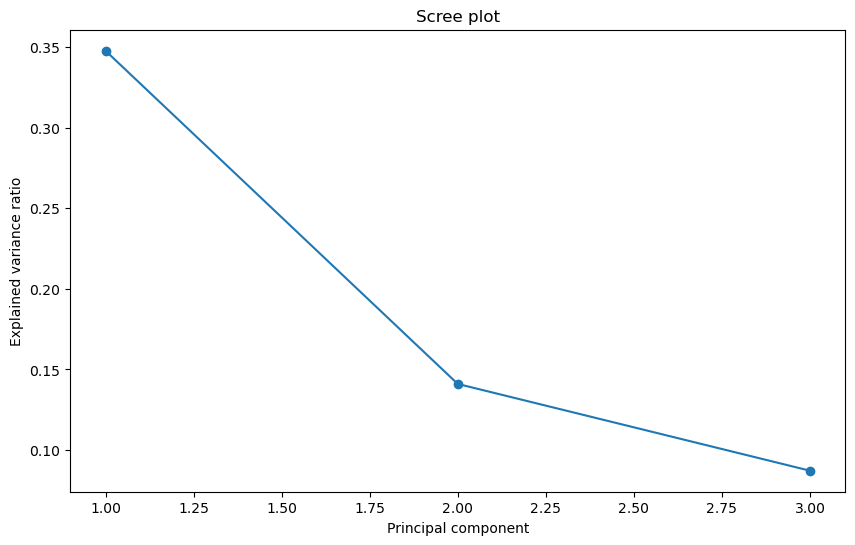

In [ ]:
# scree plot 
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree plot')
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.show()


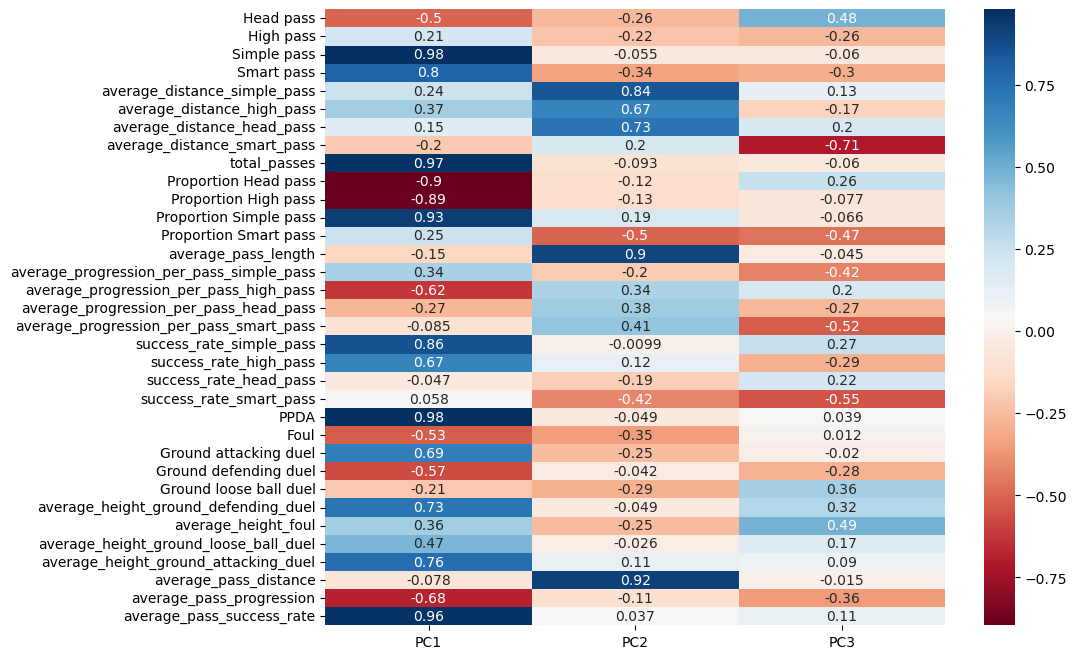

In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=features.columns) 


plt.figure(figsize=(10, 8))
sns.heatmap(loading_matrix, annot=True, cmap='RdBu', xticklabels=True, yticklabels=True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3)  # You can choose the number of clusters
clusters = kmeans.fit_predict(principalComponents)
pca_df['Cluster'] = clusters


cluster_df = pca_df.groupby('Cluster')['team'].apply(list).reset_index()

cluster_df

,Cluster,team
0,0,"[Italy, Belgium, Republic of Ireland, Austria,..."
1,1,"[Turkey, Sweden, Iceland, Albania, Northern Ir..."
2,2,"[Spain, England, Germany, France, Switzerland]"


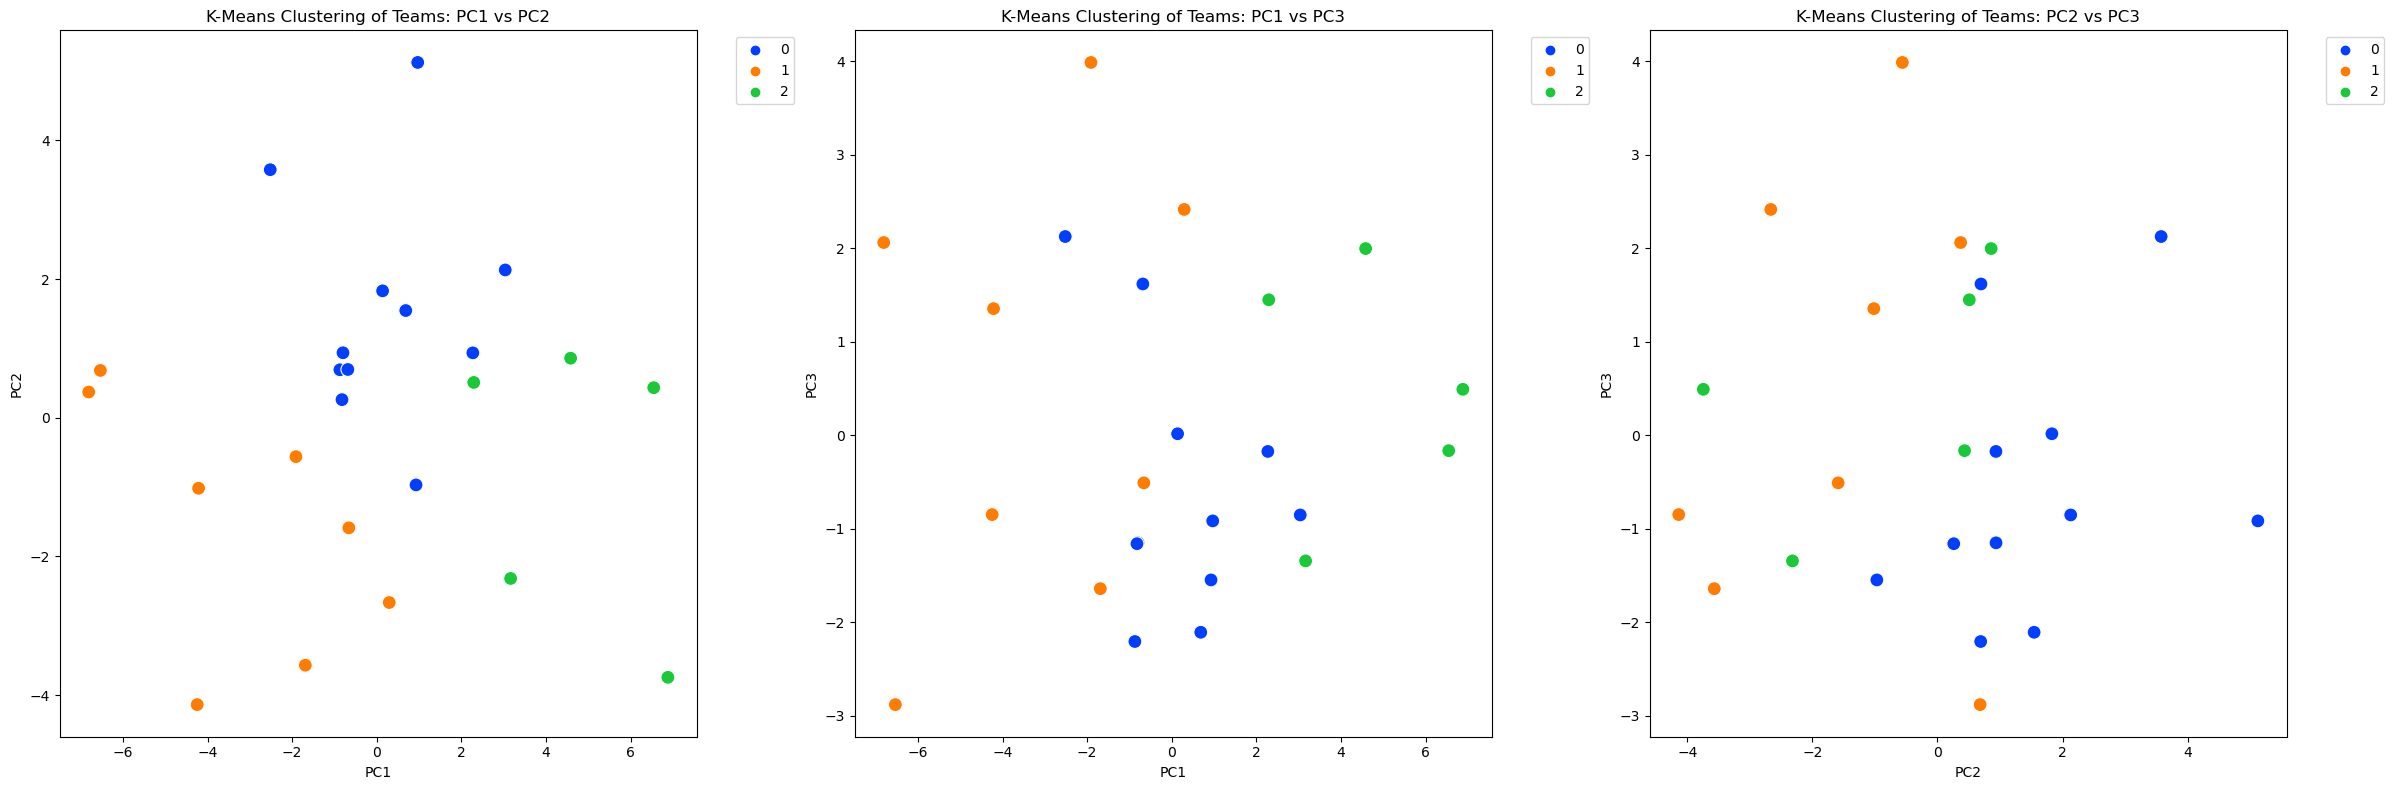

In [ ]:
# Adjusting for a single row of square subplots
fig_width = 8 * 3  # Total width of the figure to accommodate 3 square subplots horizontally
fig_height = 8  # Height of each subplot to maintain square aspect ratio
fig, axs = plt.subplots(1, 3, figsize=(fig_width, fig_height))
axs = axs.flatten()

# Define PCA components to plot against each other
pca_components = ['PC1', 'PC2', 'PC3']
combinations = [(pca_components[i], pca_components[j]) for i in range(len(pca_components)) for j in range(i+1, len(pca_components))]

for i, (pca1, pca2) in enumerate(combinations):
    # Plot each PCA component against the other with increased point sizes
    sns.scatterplot(x=pca1, y=pca2, data=pca_df, hue='Cluster', palette='bright', legend='full', ax=axs[i], s=100)  # Adjust `s` as needed for point size
    axs[i].set_title(f'K-Means Clustering of Teams: {pca1} vs {pca2}')
    axs[i].set_xlabel(pca1)
    axs[i].set_ylabel(pca2)
    axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()